In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io

%matplotlib inline

In [2]:
import nltk

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import auc, roc_auc_score, roc_curve, confusion_matrix, classification_report

from keras.models import Model, load_model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical, plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

In [3]:
df = pd.read_csv('spam.csv', encoding='latin-1')

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Number of ham and spam messages')

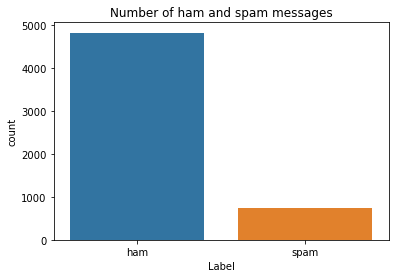

In [7]:
fig, ax = plt.subplots()
sns.countplot(df.v1, ax=ax)
ax.set_xlabel('Label')
ax.set_title('Number of ham and spam messages')

In [8]:
X = df.loc[:, 'v2'] #   The Index and the Messages
y = df.loc[:, 'v1'] #   Ham (or) Spam

In [9]:
X

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: v2, Length: 5572, dtype: object

In [10]:
y

0        ham
1        ham
2       spam
3        ham
4        ham
        ... 
5567    spam
5568     ham
5569     ham
5570     ham
5571     ham
Name: v1, Length: 5572, dtype: object

In [11]:
X_train_data, X_test_data, y_train_labels, y_test_labels = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
print("X_Train_Data Shapes: ", X_train_data.shape)
print("X_Test_Data Shapes: ", X_test_data.shape)

X_Train_Data Shapes:  (4457,)
X_Test_Data Shapes:  (1115,)


In [13]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
# Length of Each Sentence after Tokenization
sent_lens = []
for sent in X_train_data:
    sent_lens.append(len(nltk.word_tokenize(sent)))
    
print(max(sent_lens))

220


C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

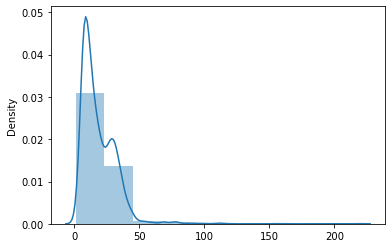

In [15]:
sns.distplot(sent_lens, bins=10, kde=True)

In [16]:
#   Length of 95% of review text to help in finding max. sequence length.
max_sequence_length = int (np.quantile(sent_lens, 0.95))
max_sequence_length

39

In [17]:

tok = Tokenizer()
tok.fit_on_texts(X_train_data.values)

vocab_length = len(tok.word_index) #len(tok.word_counts) or len(tok.index_word.keys()) will also give same results
print('No. of unique tokens(vocab_size): ', vocab_length)

X_train_sequences = tok.texts_to_sequences(X_train_data.values)
X_test_sequences = tok.texts_to_sequences(X_test_data.values)
print('No of sequences:', len(X_train_sequences)) #No of sequences will be same as the number of training samples
print(X_train_sequences[:2])

#make all sequences of equal length
X_train = pad_sequences(X_train_sequences, maxlen = max_sequence_length)
X_test = pad_sequences(X_test_sequences, maxlen = max_sequence_length)
X_train[:2]

No. of unique tokens(vocab_size):  7954
No of sequences: 4457
[[38, 30, 8, 5, 273, 1989, 81, 116, 26, 11, 1656, 322, 10, 53, 18, 299, 30, 349, 1990], [799, 15, 2555, 1442, 1127, 192, 2556, 171, 12, 98, 1991, 44, 195, 1657, 2557, 1992, 2558, 21, 9, 4, 203, 1025, 225]]


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   38,   30,
           8,    5,  273, 1989,   81,  116,   26,   11, 1656,  322,   10,
          53,   18,  299,   30,  349, 1990],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,  799,   15, 2555, 1442, 1127,  192,
        2556,  171,   12,   98, 1991,   44,  195, 1657, 2557, 1992, 2558,
          21,    9,    4,  203, 1025,  225]])

In [18]:
y_train_labels.values

array(['ham', 'spam', 'ham', ..., 'ham', 'ham', 'ham'], dtype=object)

In [19]:
le = LabelEncoder()
y_train = le.fit_transform(y_train_labels)
y_test = le.fit_transform(y_test_labels)
print(y_train)


[0 1 0 ... 0 0 0]


In [20]:
y_train_le  = y_train.reshape(-1, 1)
y_test_le  = y_test.reshape(-1, 1)
print(y_train_le)

[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]


In [21]:
def create_model(vocab_len, max_seq_len):
    inputs = Input(name='inputs', shape=[max_seq_len])   #None, 150
    layer = Embedding(vocab_length + 1, 50, input_length=max_seq_len)(inputs) #None, 150, 50
    layer = LSTM(64)(layer)  #None, 64
    layer = Dense(256,name='FC1')(layer) #None, 256
    layer = Activation('relu')(layer) #None, 256
    layer = Dropout(0.5)(layer) #None, 256
    layer = Dense(1,name='out_layer')(layer) #None, 1
    layer = Activation('sigmoid')(layer) #None, 1
    model = Model(inputs=inputs,outputs=layer)
    model.compile(loss='binary_crossentropy',optimizer=RMSprop(), metrics=['acc'])
    return model

model = create_model(vocab_length, max_sequence_length)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 39)]              0         
                                                                 
 embedding (Embedding)       (None, 39, 50)            397750    
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

In [22]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [38]:
import graphviz
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [24]:
%load_ext tensorboard
%tensorboard --logdir logs

In [25]:
filepath='model_with_best_weights.h5'

In [26]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1), 
    EarlyStopping(monitor='val_loss',min_delta=0.0001, patience=5),
    ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True, verbose=1), 
    TensorBoard(log_dir='logs', histogram_freq=1, embeddings_freq=1)
]

In [27]:
history = model.fit(X_train, y_train, 
                    batch_size=128, epochs=20, 
                    validation_split=0.2, callbacks=callbacks
                    )

Epoch 1/20
28/28 [==============================] - ETA: 0s - loss: 0.3225 - acc: 0.8693
Epoch 1: val_loss improved from inf to 0.16102, saving model to model_with_best_weights.h5
28/28 [==============================] - 11s 150ms/step - loss: 0.3225 - acc: 0.8693 - val_loss: 0.1610 - val_acc: 0.9473
Epoch 2/20
28/28 [==============================] - ETA: 0s - loss: 0.0967 - acc: 0.9790
Epoch 2: val_loss improved from 0.16102 to 0.06498, saving model to model_with_best_weights.h5
28/28 [==============================] - 2s 89ms/step - loss: 0.0967 - acc: 0.9790 - val_loss: 0.0650 - val_acc: 0.9821
Epoch 3/20
28/28 [==============================] - ETA: 0s - loss: 0.0373 - acc: 0.9902
Epoch 3: val_loss improved from 0.06498 to 0.05996, saving model to model_with_best_weights.h5
28/28 [==============================] - 2s 88ms/step - loss: 0.0373 - acc: 0.9902 - val_loss: 0.0600 - val_acc: 0.9753
Epoch 4/20
28/28 [==============================] - ETA: 0s - loss: 0.0196 - acc: 0.9944
E

In [28]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


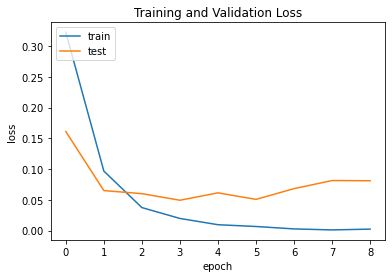

In [29]:
# summarize history for loss
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

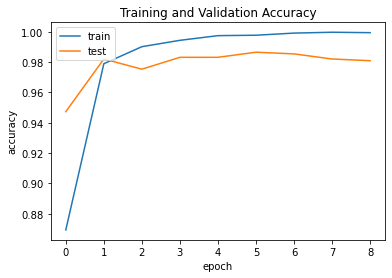

In [30]:
# summarize history for accuracy
plt.plot(history_dict['acc'])
plt.plot(history_dict['val_acc'])
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
loaded_model = load_model('model_with_best_weights.h5')
test_loss, test_acc = accr = loaded_model.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(test_loss, test_acc))

35/35 [==============================] - 2s 13ms/step - loss: 0.0651 - acc: 0.9830
Test set
  Loss: 0.065
  Accuracy: 0.983


In [32]:
# make class predictions with the model on new data
y_pred_proba = loaded_model.predict(X_test)

# y_pred = loaded_model.predict_classes(X_test)  #we can't use it on Model object. Can be used on Sequential object
print(np.round(y_pred_proba, 3))
y_pred = y_pred_proba > 0.5
y_pred

35/35 [==============================] - 1s 6ms/step
[[0.401]
 [0.001]
 [0.779]
 ...
 [0.001]
 [0.002]
 [0.974]]


array([[False],
       [False],
       [ True],
       ...,
       [False],
       [False],
       [ True]])

In [33]:
# summarize the first few cases
for i in range(5):
    print('%s => %d (expected %d)' % (X_test[i].tolist(), y_pred[i], y_test[i]))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1366, 1578, 1432, 19, 7893, 19, 19, 38, 118, 1650, 19, 738, 4, 449, 3023, 35, 1285] => 0 (expected 0)
[0, 1, 188, 11, 6440, 2, 7, 1, 135, 2, 28, 12, 4, 290, 7931, 1, 104, 33, 3, 22, 647, 15, 28, 4, 3607, 18, 374, 191, 224, 2137, 107, 433, 9, 74, 10, 5, 1097, 1806, 1171] => 0 (expected 0)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 39, 54, 258, 144, 3, 54, 21, 3428, 3, 16, 2, 173, 53, 144, 761, 264, 7182, 208] => 1 (expected 1)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 64, 33, 3, 1528, 13, 263, 53, 79, 228, 79, 3, 31, 7, 838, 69, 10, 8, 5, 168, 2, 205, 10, 54, 3, 499, 14, 8, 46] => 0 (expected 0)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 715, 29, 357, 532, 622, 15, 1107, 528, 706, 49, 435, 19, 98, 563, 496, 292, 71, 521, 2, 906, 1546, 138, 1200, 2216] => 1 (expected 1)


In [34]:
print(confusion_matrix(y_test, y_pred))

[[965   0]
 [ 19 131]]


In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       1.00      0.87      0.93       150

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [36]:
#calculate the roc auc score
auc = roc_auc_score(y_test, y_pred_proba)
print('AUC: %.3f' % auc)

AUC: 0.990


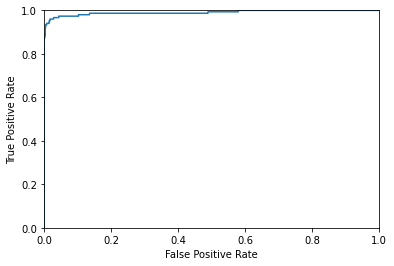

In [37]:
#plot the roc curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_proba)

def plot_roc_curve(fpr,tpr): 
  import matplotlib.pyplot as plt
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  
plot_roc_curve (fpr_keras, tpr_keras)